/Users/mac/Documents/separability/.venv/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:582: UserWarning: n_components is too large: it will be set to 2
  warnings.warn(


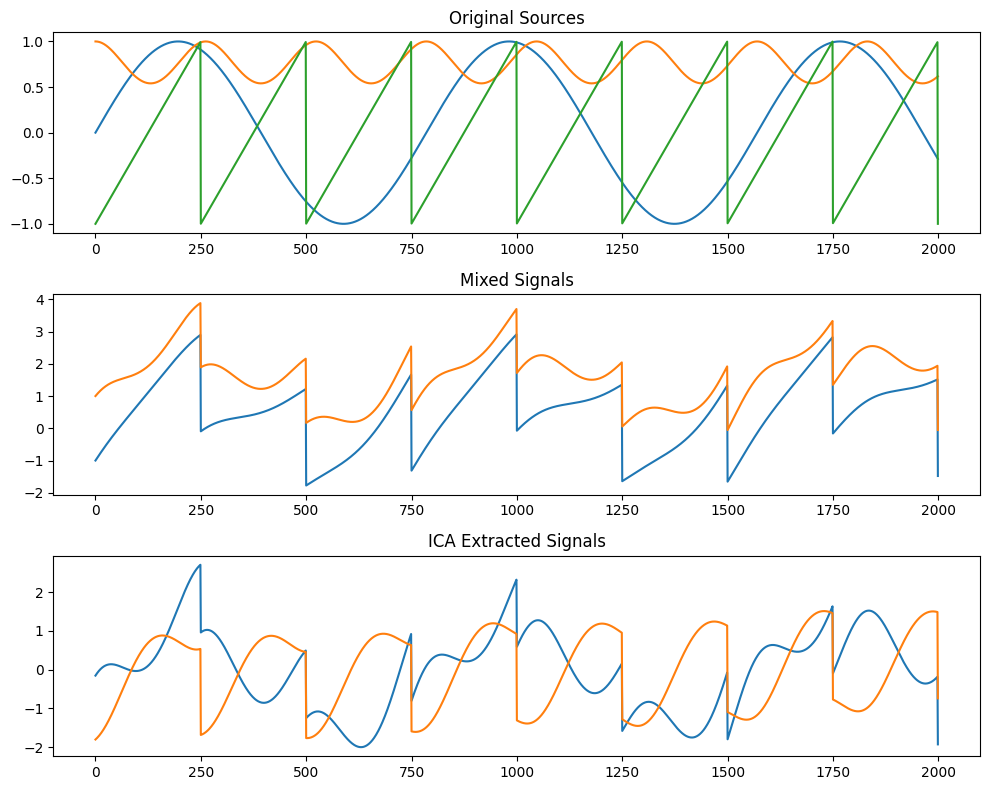

In [13]:
#!pip install numpy scikit-learn -qq
import numpy as np
from sklearn.decomposition import FastICA
from scipy import signal

# Generate synthetic data
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

# Create three sources
s1 = np.sin(2 * time)
s2 = np.cos(np.sin(3 * time))
s3 = signal.sawtooth(2 * np.pi * time)

# Stack the sources
S = np.c_[s1, s2, s3]

# Mix the sources
A = np.array([[1, 1], [0.5, 2], [1.5, 1.0]])  # 3x2 Mixing matrix
X = S.dot(A)  # Mixed signals

# Apply ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Get the estimated sources
A_ = ica.mixing_  # Get the estimated mixing matrix

# Now, S_ contains the signals estimated to be the independent sources
# Plot
plt.figure(figsize=(10, 8))

plt.subplot(3, 1, 1)
plt.title("Original Sources")
plt.plot(S)

plt.subplot(3, 1, 2)
plt.title("Mixed Signals")
plt.plot(X)

plt.subplot(3, 1, 3)
plt.title("ICA Extracted Signals")
plt.plot(S_)

plt.tight_layout()
plt.show()


In [15]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

# Create three sources
s1 = np.sin(2 * time)
s2 = np.sign(np.sin(3 * time))
s3 = signal.sawtooth(2 * np.pi * time)

# Stack the sources
S = np.c_[s1, s2, s3]

# Mix the sources into two observed dimensions
A = np.array([[1, 1], [0.5, 2], [1.5, 1.0]])  # 3x2 Mixing matrix
X = S.dot(A)  # Mixed 2D signals

# Apply overcomplete ICA
n_sources = 3
weights, S_ = ica(X.T, n_sources, contrastfunction='tanh')

# Plot
plt.figure(figsize=(10, 10))

plt.subplot(4, 1, 1)
plt.title("Original Sources")
plt.plot(S)

plt.subplot(4, 1, 2)
plt.title("Mixed Signals")
plt.plot(X)

plt.subplot(4, 1, 3)
plt.title("ICA Extracted Signals")
plt.plot(S_.T)

plt.tight_layout()
plt.show()


TypeError: 'FastICA' object is not callable

tensor(1.0003) tensor(1.0003)


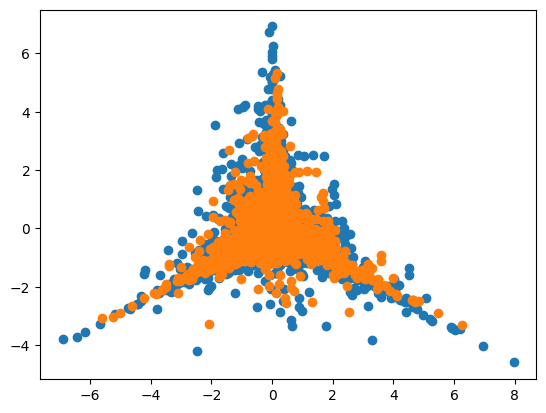

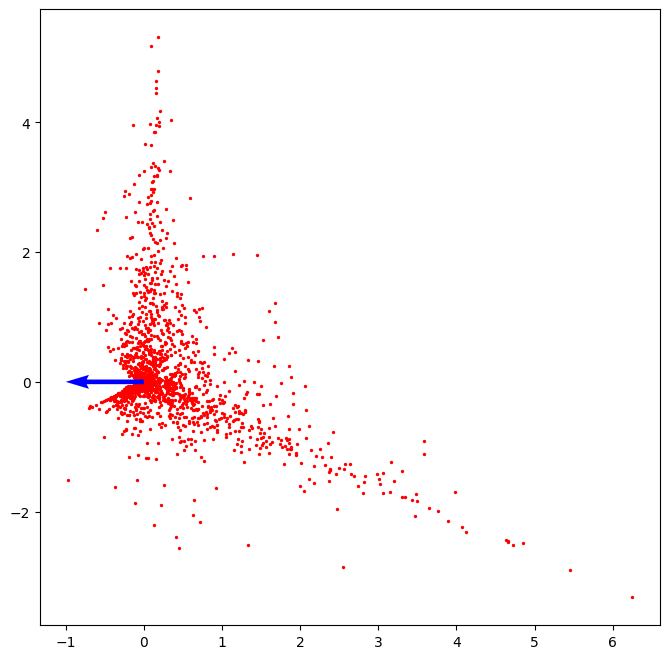

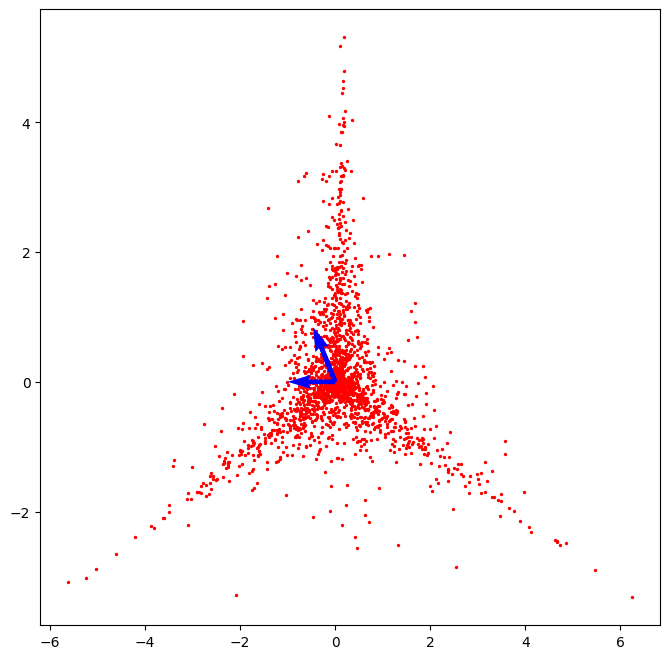

In [158]:
import torch
import torch.optim as optim

def whiten(X):
    """Whitening function for preprocessing"""
    X_mean = torch.mean(X, dim=1, keepdim=True)
    X = X - X_mean
    cov = torch.mm(X, X.t()) / X.size(1)
    U, S, V = torch.svd(cov)
    X_white = torch.mm(U, torch.mm(torch.diag(1.0 / torch.sqrt(S)), torch.mm(U.t(), X)))
    return X_white

def whiten(X):
    """Whitening function that returns the whitened data, 
       the whitening matrix, and its inverse."""
    X_mean = torch.mean(X, dim=1, keepdim=True)
    X_centered = X - X_mean
    cov = torch.mm(X_centered, X_centered.t()) / X.size(1)
    U, S, V = torch.svd(cov)
    W_white = torch.mm(U, torch.mm(torch.diag(1.0 / torch.sqrt(S)), U.t()))
    W_white_inv = torch.mm(U, torch.mm(torch.diag(torch.sqrt(S)), U.t()))
    X_white = W_white @ X
    return X_white, W_white, W_white_inv

def overcomplete_ica(X, num_sources, max_iterations=1000, learning_rate=1e-3):
    """Overcomplete ICA using PyTorch"""
    num_dimensions, num_samples = X.size()

    # Whitening
    X_white, W_white, W_white_inv = whiten(X)

    # Initialize demixing matrix W with random values
    W = torch.randn((num_sources, num_dimensions), requires_grad=True)
    
    optimizer = optim.Adam([W], lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.95)


    for iteration in range(max_iterations):
        optimizer.zero_grad()

        # Estimate sources
        S = W @ X_white

        # Using Negentropy as a measure of non-Gaussianity
        # g(u) = log(cosh(u))
        # g'(u) = tanh(u)
        g = torch.log(torch.cosh(S))
        g_prime = torch.tanh(S)
        
        loss = torch.sum(g) - torch.sum((W.t() @ g_prime))

        # Backpropagate
        (-loss).backward()
        
        # Update and normalize W
        optimizer.step()
        scheduler.step()

        with torch.no_grad():
            W += learning_rate * W.grad
            W /= torch.norm(W, dim=1, keepdim=True)

        # Display the loss
        if iteration % 100 == 0:
            print(f"Iteration {iteration}, Loss: {loss.item()}")

    return W, S, W_white, W_white_inv

# Test
num_samples = 2000
num_dimensions = 2
num_sources = 3  # > num_dimensions

# Generate some toy data as mixed signals
torch.manual_seed(0)
S_true = torch.randn((num_sources, num_samples))


# Example
loc, scale = 0.0, 1.0  # the scale parameter, sometimes referred to as diversity
S_true = torch.distributions.Laplace(loc, scale).rsample((num_sources, num_samples))
S_true = torch.softmax(S_true, dim=0) * torch.norm(S_true, dim=0)

#A = torch.randn((num_dimensions, num_sources))
directions = torch.tensor([0, 2*torch.pi/3, 4*torch.pi/3])
A_X = torch.sin(directions)
A_Y = torch.cos(directions)
A   = torch.stack([A_X, A_Y])
X   = A @ S_true

x_i, y_i = X[0], X[1]
plt.scatter(x_i, y_i)

X_white, W_white, W_white_inv = whiten(X)
x_i, y_i = X_white[0], X_white[1]
plt.scatter(x_i, y_i)
print(torch.std(x_i), torch.std(y_i))

if False:
    # Extract sources
    W_estimated, S_estimated, W_white, W_white_inv = overcomplete_ica(X, num_sources)
    #print(W_estimated.shape, S_estimated.shape, W_white.shape, W_white_inv.shape)
    X_reconstructed = W_white_inv @ W_estimated.T @ S_estimated

    print(A)
    print(W_estimated.T)

    print("\nreconstructed inputs:")
    print(X[:2, :3].numpy())
    print(X_reconstructed[:2, :3].detach().numpy())

    print("\nreconstructed signals:")
    print(torch.nn.functional.layer_norm(S_true.T, (3,)).T[:3,:5].numpy())
    print(S_estimated[:3, :5].detach().numpy())
    
if False:
    from sklearn.decomposition import FastICA, KernelPCA

    # Embed to 3D using Kernel PCA
    kpca = KernelPCA(n_components=3, kernel="rbf", fit_inverse_transform=True)
    X_kpca = kpca.fit_transform(X_white.T.numpy())
    print("KPCA shape", X_kpca.shape)
    
    # ICA
    ica = FastICA(n_components=3)
    S_ica = ica.fit_transform(X_kpca)
    A_ica = ica.mixing_
    
    A_2d = kpca.inverse_transform(A_ica)

    print("ICA", A_ica.T, A_2d)

    # Plot
    plt.figure(figsize=(8,8))

    # Original Data
    plt.scatter(X_white[0], X_white[1], s=2, color='red', label='Original Data')

    # ICA Directions
    for comp in (A_2d*3):
        plt.quiver(0, 0, comp[0], comp[1], angles='xy', scale_units='xy', scale=1, color='blue', label='ICA Directions')

    plt.legend()
    plt.title('ICA on Data')
    plt.grid()
    plt.show()
    
if False:
    def remove_projection(data, direction, threshold=0.5):
        # Normalize the direction vector
        direction_normalized = direction / np.linalg.norm(direction)
        data_norms = np.linalg.norm(data, axis=-1)
        data_normalized = data / data_norms[:, None]
        
        # Compute the projection of data onto the direction
        dot_products = data_normalized @ direction_normalized
        discounts    = data * np.clip(dot_products, a_min=0, a_max=1)
        
        return data - discounts

    X_np = X_white.numpy().T

    # First ICA run
    ica1 = FastICA(n_components=1)
    S_ica1 = ica1.fit_transform(X_np)
    A_ica1 = ica1.mixing_

    # Remove the projection onto the first ICA direction
    X_np_removed = remove_projection(X_np, A_ica1)
    
    # Plotting...
    plt.figure(figsize=(8,8))
    plt.scatter(X_np_removed[:, 0], X_np_removed[:, 1], s=2, color='red', label='Original Data')
    plt.quiver(0, 0, A_ica1[0], A_ica1[1], angles='xy', scale_units='xy', scale=1, color='blue', label='ICA Directions')

    # Second ICA run on the modified data
    ica2 = FastICA(n_components=1)
    S_ica2 = ica2.fit_transform(X_np_removed)
    A_ica2 = ica2.mixing_

    # Now you have two directions from A_ica1 and A_ica2
    # The third direction can be approximated by taking the orthogonal direction to these two.
    #A_ica3 = np.cross(A_ica1.T, A_ica2.T)
    
    # Second ICA run on the modified data
    ica3 = FastICA(n_components=1)
    S_ica3 = ica3.fit_transform(X_np_removed)
    A_ica3 = ica3.mixing_

    # Plotting...
    plt.figure(figsize=(8,8))

    # Original Data
    plt.scatter(X_white[0], X_white[1], s=2, color='red', label='Original Data')

    # ICA Directions
    for comp in [A_ica1, A_ica2, A_ica3]:
        plt.quiver(0, 0, comp[0], comp[1], angles='xy', scale_units='xy', scale=1, color='blue', label='ICA Directions')



tensor(1.0003) tensor(1.0003)


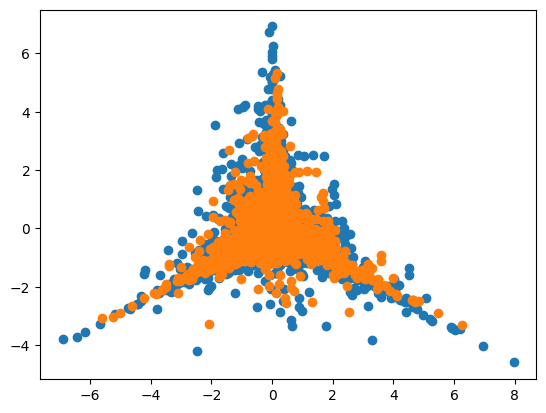

In [201]:
# Generate Data
# Test
num_samples = 2000
num_dimensions = 2
num_sources = 3  # > num_dimensions

# Generate some toy data as mixed signals
torch.manual_seed(0)
S_true = torch.randn((num_sources, num_samples))


# Example
loc, scale = 0.0, 1.0  # the scale parameter, sometimes referred to as diversity
S_true = torch.distributions.Laplace(loc, scale).rsample((num_sources, num_samples))
S_true = torch.softmax(S_true, dim=0) * torch.norm(S_true, dim=0)

#A = torch.randn((num_dimensions, num_sources))
directions = torch.tensor([0, 2*torch.pi/3, 4*torch.pi/3])
A_X = torch.sin(directions)
A_Y = torch.cos(directions)
A   = torch.stack([A_X, A_Y])
X   = A @ S_true

x_i, y_i = X[0], X[1]
plt.scatter(x_i, y_i)

X_white, W_white, W_white_inv = whiten(X)
x_i, y_i = X_white[0], X_white[1]
plt.scatter(x_i, y_i)
print(torch.std(x_i), torch.std(y_i))
        

Epoch 0: Loss = 0.764713139206171
Epoch 5: Loss = 0.0777544009424746
Epoch 9: Loss = 0.07736925530806184
tensor([0.1489, 1.3664]) (tensor([0.0266, 1.3812]), tensor([0.0000, 1.3752, 0.0000]))


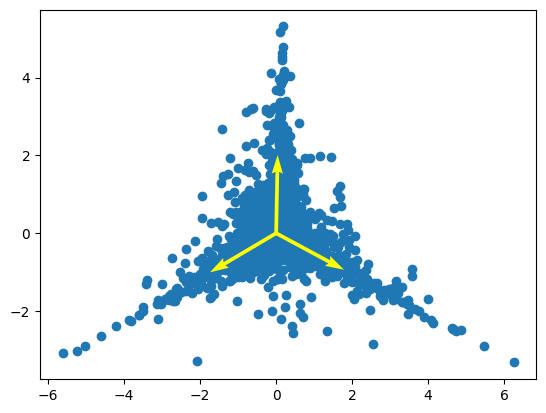

In [222]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SparseVAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(SparseVAE, self).__init__()
        
        # Encoder
        self.pre_bias  = nn.Parameter(torch.zeros(input_dim))
        self.mid_bias  = nn.Parameter(torch.zeros(latent_dim))
        self.post_bias = lambda : - self.pre_bias
        
        self.encoder = nn.Linear(input_dim, latent_dim, bias=False)
        self.act_fn  = nn.ReLU()
        self.decoder = lambda z : F.linear(z, self.encoder.weight.T)

        
    def forward(self, x):
        mid   = self.encoder(x)
        mid   = self.act_fn(mid)
        recon = self.decoder(mid)
        return recon, mid

def loss_function(x, x_reconstructed, mid, kl_weight=5e-4):
    MSE = F.mse_loss(x, x_reconstructed, reduction='sum')
    L1  = torch.abs(mid).sum() * kl_weight
    
    return MSE + L1

# Hyperparameters
input_dim = 2
latent_dim = 3
lr = 2e-3
batch_size = 10
epochs = 10

# Data
from torch.utils.data import DataLoader, TensorDataset
dataset = TensorDataset(X_white.T)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Model & Optimizer
model = SparseVAE(input_dim, latent_dim)  # Move to GPU if available
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Training loop
for epoch in range(epochs):
    model.train()
    train_loss = 0
    for batch in dataloader:
        data = batch[0]
        
        optimizer.zero_grad()
        
        data_recon, mid = model(data)
        loss = loss_function(data, data_recon, mid)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    if epoch % 5 == 0:
        print(f"Epoch {epoch}: Loss = {train_loss / len(dataloader.dataset)}")
print(f"Epoch {epoch}: Loss = {train_loss / len(dataloader.dataset)}")
        
model.eval()
x = X_white.T[0]
with torch.no_grad():
    print(x, model(x))
    
plt.scatter(X_white[0], X_white[1])

for (_x, _y) in model.encoder.weight.detach().numpy():
    plt.quiver(0, 0, _x*2, _y*2, angles='xy', scale_units='xy', scale=1, color='yellow', label='ICA Directions')